# Goal

My `bicorr_hist_master` matrix is enormous, and it takes up 15 GB of space (if 0.25 ns time binning). Most of it is empty, so I could instead convert it to a sparse matrix and store a much smaller matrix to file. Investigate this.

Start by loading a `bicorr_hist_master` into memory for this study. 

Updates
-------
* 3/22/2017: First version; Implement sparse matrices
* 7/5/2017: Implement `det_df` pandas dataframe for loading detector pair indices, angles

In [1]:
import numpy as np
import scipy.io as sio
import os
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors
import inspect
from tqdm import tqdm

In [4]:
sys.path.append('../scripts/')

In [5]:
import bicorr as bicorr

In [6]:
%load_ext autoreload
%autoreload 2

# Generate `bicorr_hist_master` from another dataset

Use the function I have already built into my `bicorr.py` functions. I don't have any `bicorr_hist_master` files stored to disk because they are so large, so I will load a `bicorr` text file and build a `bicorr_hist_master` array.

In [7]:
help(bicorr.load_bicorr)

Help on function load_bicorr in module bicorr:

load_bicorr(folder_number=None, bicorr_path=None, root_path=None)
    Load a data matrix of bicorr data into current python session
    
    Parameters
    ----------
    folder_number : int, optional
        Folder from which to load bicorr file
        Bicorr filename will be bicorr# (with folder_number)
    bicorr_path : str, optional
        Full path of bicorr file, including filename
    root_path : int, optional
        Relative path to folder where data folders exist (1, 2, 3, etc.). default = cwd
    
    
    Returns
    -------
    bicorr_data : ndarray
        Each element contains the following info for one bicorrelation pair
        Columns are 0: event, np.int32
                    1: det1ch, np.int8
                    2: det1par, np.int8
                    3: det1t, np.float16
                    4: det2ch, np.int8
                    5: det2par, np.int8
                    6: det2t, np.float16



Where are the files I want to import? Use the same file that I use in my analysis `build_bicorr_hist_master`.

In [10]:
os.listdir('../datar/1')

['bicorr1', 'bicorr1_part', 'cced1', 'fig', 'timeOffset.txt']

I am going to provide the full `bicorr_path` as input.

In [12]:
bicorr_data = bicorr.load_bicorr(bicorr_path = '../datar/1/bicorr1_part')

Now I will build `bicorr_hist_master`.

In [14]:
det_df = bicorr.load_det_df()
dt_bin_edges, num_dt_bins = bicorr.build_dt_bin_edges()

In [15]:
bhm = bicorr.alloc_bhm(len(det_df),4,num_dt_bins)

In [17]:
bhm = bicorr.fill_bhm(bhm, bicorr_data, det_df, dt_bin_edges)

100%|##########| 10000/10000 [00:00<00:00, 21675.46it/s]


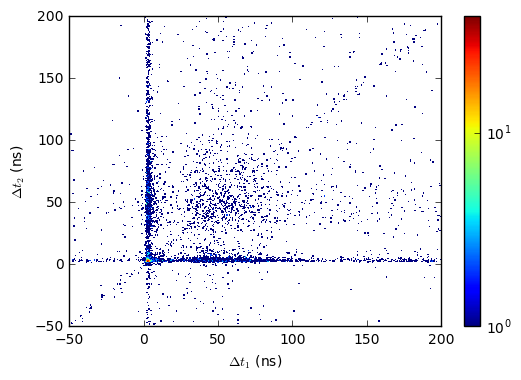

In [18]:
bhp = bicorr.build_bhp(bhm,dt_bin_edges)[0]
bicorr.bicorr_plot(bhp, dt_bin_edges, show_flag = True)

# What is a sparse matrix?

See documentation on Wikipedia: https://en.wikipedia.org/wiki/Sparse_matrix

A **sparse matrix** has most of its elements equal to zero. The number of zero-valued elements divided by the total number of elements is called its **sparsity**, and is equal to 1 minus the **density** of the matrix.



## How sparse is my matrix?

How much of my matrix is empty? 

In [20]:
np.count_nonzero(bhm)

8026

In [21]:
bhm.size

3960000000

In [23]:
1-np.count_nonzero(bhm)/bhm.size

0.9999979732323232

Wow... My matrix is 98.8% sparse. I should definitely be using a sparse matrix to store the information. 

## Investigate sparse matrix format with `scipy.sparse`

SciPy has a 2-D sparse matrix package for numeric data. Documentation is available here: <https://docs.scipy.org/doc/scipy/reference/sparse.html#usage-information>.  How do I use it? It will not be simple since my numpy array has four dimensions.

In [14]:
from scipy import sparse

I am following this StackOverflow for how to convert the array to a sparse matrix: http://stackoverflow.com/questions/7922487/how-to-transform-numpy-matrix-or-array-to-scipy-sparse-matrix

In [15]:
s_bicorr_hist_Master = sparse.csr_matrix(bicorr_hist_master[0,0,:,:])

In [16]:
print(s_bicorr_hist_Master)

  (71, 85)	1
  (72, 82)	1
  (73, 127)	1
  (73, 148)	1
  (74, 77)	1
  (74, 84)	1
  (74, 93)	2
  (75, 94)	2
  (76, 83)	1
  (76, 85)	1
  (76, 88)	1
  (76, 89)	1
  (76, 90)	1
  (76, 91)	1
  (76, 94)	1
  (76, 100)	1
  (76, 106)	1
  (76, 107)	1
  (76, 115)	1
  (77, 81)	1
  (77, 85)	1
  (77, 86)	1
  (77, 89)	1
  (77, 90)	1
  (77, 91)	1
  :	:
  (219, 119)	1
  (219, 120)	1
  (219, 121)	1
  (221, 241)	1
  (222, 94)	1
  (222, 100)	1
  (222, 205)	1
  (223, 104)	1
  (223, 135)	1
  (224, 201)	1
  (227, 104)	1
  (231, 92)	1
  (231, 106)	1
  (232, 84)	1
  (234, 110)	1
  (234, 226)	1
  (236, 93)	1
  (236, 223)	1
  (237, 87)	1
  (238, 82)	1
  (242, 111)	1
  (242, 119)	1
  (244, 116)	1
  (244, 131)	1
  (245, 118)	1


In [17]:
type(s_bicorr_hist_Master)

scipy.sparse.csr.csr_matrix

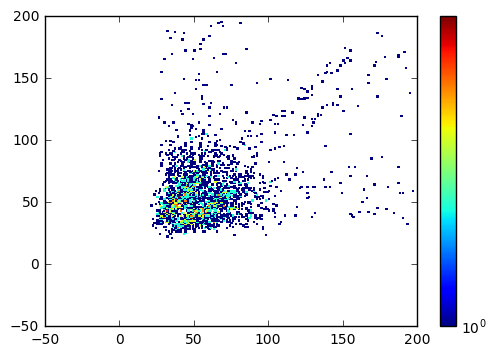

In [18]:
plt.pcolormesh(dt_bin_edges,dt_bin_edges,bicorr_hist_master[0,0,:,:],norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.show()

It looks like this scipy sparse matrix function will not suit my needs because it is limited to two-dimensional numpy arrays. I need to be able to store a four-dimensional array as a sparse matrix. I will try to write my own technique in the following section.

# Build my own sparse matrix generator

It looks like the scipy sparse matrix functions are limited to two-dimensional numpy arrays. So I will try building my own function.

## Set up formatting

I am going to build a numpy array with a specified numpy data type (`dType`). There will be five pieces of data for each element in the array.

* 4-dimensional index of element
    * `pair_i`: Detector pair, length = 990. Use `np.uint16`.
    * `type_i`: Interaction type, length 4 (0=nn, 1=np, 2=pn, 3=pp). Use `np.uint8`.
    * `det1t_i`: dt bin for detector 1 (up to 1000). Use `np.uint16`.
    * `det2t_i`: dt bin for detector 2 (up to 1000). Use `np.uint16`.
* `count`: Value of that element. Use `np.uint64`. 

First establish the formatting of each element in the array.

In [24]:
sparseType = np.dtype([('pair_i', np.uint16), ('type_i', np.uint8), ('det1t_i', np.uint16), ('det2t_i', np.uint16), ('count', np.uint32)])

## Access nonzero count information

In [25]:
num_nonzero = np.count_nonzero(bhm)

In [26]:
print(num_nonzero)

8026


I'm going to ask numpy to make an array of the indices for non-zero values with `np.nonzero`. Numpy will return it as an array of tuples organized somewhat strangely. Explore how the indexing works.

First store the indices as tuples using `np.nonzero`. The tuples are stored as four massive tuples of 2767589 elements. They are so large that I can't print them to my screen. How do I extract the four arguments for the position of the $i^{th}$ nonzero value?

In [28]:
i_nonzero = np.nonzero(bhm)

In [29]:
counts = bhm[i_nonzero]

In [30]:
counts[600:800]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=uint32)

How do I find the element at the top there that is equal to three? It is at the 627$^{th}$ index position in `i_nonzero` and `counts`. How do I find the corresponding indices in `bicorr_hist_master`?

In [31]:
i = 637
counts[637]

1

In [32]:
counts[i]

1

In [33]:
i_nonzero[0][i]

100

In [34]:
i_nonzero[1][i]

1

In [35]:
i_nonzero[2][i]

219

In [36]:
i_nonzero[3][i]

211

Can I call them all at once? It doesn't seem so...

In [37]:
i_nonzero[:][i]

IndexError: tuple index out of range

In [41]:
bhm[100,1,219,211]

1

## Write nonzero count information to sparse array `sparse_bhm`

Loop through all nonzero counts and store the information.

In [42]:
sparse_bhm = np.zeros(num_nonzero,dtype=sparseType)

In [45]:
for i in tqdm(np.arange(0,num_nonzero),ascii=True):
    sparse_bhm[i]['pair_i']  = i_nonzero[0][i]
    sparse_bhm[i]['type_i']  = i_nonzero[1][i]
    sparse_bhm[i]['det1t_i'] = i_nonzero[2][i]
    sparse_bhm[i]['det2t_i'] = i_nonzero[3][i]
    sparse_bhm[i]['count']   = counts[i]
              
print(sparse_bhm[0:20])

100%|##########| 8026/8026 [00:00<00:00, 92371.46it/s]


[(0, 0, 338, 745, 1) (0, 0, 364, 339, 1) (0, 1, 468, 209, 1)
 (0, 1, 529, 212, 1) (0, 2, 214, 216, 1) (0, 2, 216, 486, 1)
 (0, 2, 305, 309, 1) (0, 3, 215, 362, 1) (1, 2, 212, 390, 1)
 (1, 3, 209, 213, 1) (1, 3, 209, 217, 1) (1, 3, 213, 214, 1)
 (1, 3, 396, 229, 1) (2, 1, 92, 208, 1) (2, 1, 415, 212, 1)
 (2, 1, 447, 247, 1) (2, 1, 559, 533, 1) (2, 2, 211, 356, 1)
 (2, 2, 528, 960, 1) (2, 3, 211, 214, 1)]


In [46]:
sparse_bhm[0]

(0, 0, 338, 745, 1)

In [47]:
bhm[0,0,338,745]

1

Functionalize this in my `bicorr` module. 

In [48]:
print(inspect.getsource(bicorr.generate_sparse_bhm))

def generate_sparse_bhm(bicorr_hist_master, disable_tqdm = False):
    """
    Generate sparse version of bicorr_hist_master for storing to file. 
    
    Parameters
    ----------
    bicorr_hist_master : ndarray
        2d bicorrelation histogram
        Dimension 0: detector pair, use dictionary `dict_pair_to_index`  
        Dimension 1: interaction type, length 4. (0=nn, 1=np, 2=pn, 3=pp)  
        Dimension 2: dt bin for detector 1
        Dimension 3: dt bin for detector 2
    disable_tqdm : bool, optional
        Flag to disable tqdm progress bar
        
    Returns
    -------
    sparse_bhm : ndarray
        Length is equal to the number of nonzero elements in bicorr_hist_master
        dType = ('pair_i', np.uint16)  Indices in bicorr_hist_master
                ('type_i', np.uint8)    ''
                ('det1t_i', np.uint16)  ''
                ('det2t_i', np.uint16)  ''
                ('count', np.uint32)]) Number of counts    
    """
    # Which elements in bicorr_his

Start over and try generating `sparse_bhm` from `bicorr_hist_master`. 

In [49]:
sparse_bhm = bicorr.generate_sparse_bhm(bhm)

100%|##########| 8026/8026 [00:00<00:00, 97352.39it/s]


In [50]:
sparse_bhm[0:20]

array([(0, 0, 338, 745, 1), (0, 0, 364, 339, 1), (0, 1, 468, 209, 1),
       (0, 1, 529, 212, 1), (0, 2, 214, 216, 1), (0, 2, 216, 486, 1),
       (0, 2, 305, 309, 1), (0, 3, 215, 362, 1), (1, 2, 212, 390, 1),
       (1, 3, 209, 213, 1), (1, 3, 209, 217, 1), (1, 3, 213, 214, 1),
       (1, 3, 396, 229, 1), (2, 1, 92, 208, 1), (2, 1, 415, 212, 1),
       (2, 1, 447, 247, 1), (2, 1, 559, 533, 1), (2, 2, 211, 356, 1),
       (2, 2, 528, 960, 1), (2, 3, 211, 214, 1)], 
      dtype=[('pair_i', '<u2'), ('type_i', 'u1'), ('det1t_i', '<u2'), ('det2t_i', '<u2'), ('count', '<u4')])

## Store `sparse_bhm`, `dt_bin_edges` to disk and reload

In order to make this useful, I need a clean and simple way of storing the sparse matrix to disk and reloading it. I used to save the following three variables to disk:

* `bicorr_hist_master`
* `dict_pair_to_index`
* `dt_bin_edges`

Instead I will save the following three variables:

* `sparse_bhm`
* `det_df`
* `dt_bin_edges`

Use the same `np.save` technique and try it here:

In [43]:
np.savez('sparse_bhm', det_df = det_df, dt_bin_edges = dt_bin_edges, sparse_bhm=sparse_bhm)

This went much faster, as the `bicorr_hist_master` was 15 GB in size and this is only 30 MB in size. What a difference!

Write this into a function, and provide an optional destination folder for saving.

In [51]:
help(bicorr.save_sparse_bhm)

Help on function save_sparse_bhm in module bicorr:

save_sparse_bhm(sparse_bhm, dt_bin_edges, save_folder=None)
    Save sparse_bhm, and dt_bin_edges to .npz file in local folder. (Reload using load_sparse_bhm function)
    
    Parameters
    ----------
    sparse_bhm : ndarray
        Length is equal to the number of nonzero elements in bicorr_hist_master
        dType = ('pair_i', np.uint16)  Indices in bicorr_hist_master
                ('type_i', np.uint8)    ''
                ('det1t_i', np.uint16)  ''
                ('det2t_i', np.uint16)  ''
                ('count', np.uint32)]) Number of counts 
    dt_bin_edges : ndarray
        Edges of time bin array in ns
    save_folder : str, optional
        Optional destination folder. If None, then save in current working directory



In [53]:
bicorr.save_sparse_bhm(sparse_bhm, dt_bin_edges, '../datar')

## Compare size of `sparse_bhm` and `bicorr_hist_master`

In [54]:
sys.getsizeof(bhm)

15840000144

In [55]:
sys.getsizeof(sparse_bhm)

88382

In [58]:
sys.getsizeof(sparse_bhm)/sys.getsizeof(bhm)

5.5796716664474295e-06

This is for a partial data set. In a larger data set (tested separately), I reduced my storage needs to 1.5%... hurrah! That is a significant change, and makes it possible to store the data on my local machine.

# Load `sparse_bhm` and populate `bicorr_hist_master`

## Load `sparse_bhm`

I am going to try loading `sparse_bhm` from file and producing `bicorr_hist_master`. Use the functions I just created for loading `sparse_bhm`. (Restart Python kernel from here to make sure it works). 

In [49]:
os.listdir()

['.ipynb_checkpoints',
 'implement_sparse_matrix.ipynb',
 'sparse_bhm.npz',
 'sparse_folder',
 'subfolder']

In [50]:
help(bicorr.load_sparse_bhm)

Help on function load_sparse_bhm in module bicorr:

load_sparse_bhm(filepath=None)
    Load .npz file containing `sparse_bhm`, `dict_pair_to_index`, and `dt_bin_edges`. This file was probably generated by the function `save_sparse_bhm`.
    
    Parameters
    ----------    
    filepath : str, optional
        Where is the `sparse_bhm.npz` file located? If = none, look for it in the current working directory
        
    Returns
    -------
    sparse_bhm : ndarray
        Length is equal to the number of nonzero elements in bicorr_hist_master
        dType = ('pair_i', np.uint16)  Indices in bicorr_hist_master
                ('type_i', np.uint8)    ''
                ('det1t_i', np.uint16)  ''
                ('det2t_i', np.uint16)  ''
                ('count', np.uint32)]) Number of counts 
    dict_pair_to_index : dict
        Maps detector pair index (100*det1ch+det2ch) to the index of that detector pair in bicorr_hist_master 
    dt_bin_edges : ndarray
        Edges of time bin 

In [9]:
os.listdir('subfolder')

['sparse_bhm.npz']

In [10]:
sparse_bhm, det_df, dt_bin_edges = bicorr.load_sparse_bhm(filepath = "subfolder")

In [12]:
who

bicorr	 det_df	 dt_bin_edges	 inspect	 matplotlib	 np	 os	 plt	 sio	 
sparse_bhm	 sys	 tqdm	 


In [13]:
sparse_bhm.size

2258910

In [16]:
print(sparse_bhm[0:10])

[(0, 0, 5, 16, 1) (0, 0, 9, 481, 1) (0, 0, 19, 122, 1) (0, 0, 77, 465, 1)
 (0, 0, 93, 132, 1) (0, 0, 99, 325, 1) (0, 0, 113, 155, 1)
 (0, 0, 133, 180, 1) (0, 0, 199, 167, 1) (0, 0, 208, 417, 1)]


## Populate `bicorr_hist_master`

The only dimension in the size of `bicorr_hist_master` that would change would be the number of time bins. Otherwise, the number of detector pairs and the number of interaction types I am recording will stay the same. Use the functions I have already developed to allocate the array for `bicorr_hist_master`.

In [21]:
bicorr_hist_master = bicorr.alloc_bhm(len(det_df),4,len(dt_bin_edges)-1)

Now I need to loop through `sparse_bhm` and fill `bicorr_hist_master` with the count at the corresponding index. What does `sparse_bhm` look like again?

In [19]:
sparse_bhm[0]

(0, 0, 5, 16, 1)

Fill one element

In [20]:
i = 0
bicorr_hist_master[sparse_bhm[i][0],sparse_bhm[i][1],sparse_bhm[i][2],sparse_bhm[i][3]] = sparse_bhm[i][4]

In [21]:
print(bicorr_hist_master[sparse_bhm[i][0],sparse_bhm[i][1],sparse_bhm[i][2],sparse_bhm[i][3]])

1


Fill all of the elements

In [22]:
for i in tqdm(np.arange(0,sparse_bhm.size)):
    bicorr_hist_master[sparse_bhm[i][0],sparse_bhm[i][1],sparse_bhm[i][2],sparse_bhm[i][3]] = sparse_bhm[i][4]
    

100%|██████████| 2258910/2258910 [00:08<00:00, 273449.31it/s]


In [23]:
np.max(bicorr_hist_master)

40

Plot it to see if that looks correct.

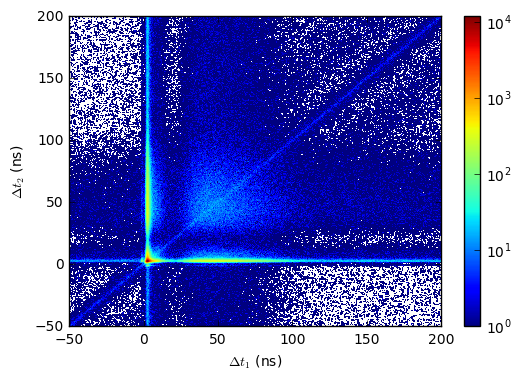

In [25]:
bicorr_hist_plot = bicorr.build_bicorr_hist_plot(bicorr_hist_master,dt_bin_edges)[0]
bicorr.bicorr_plot(bicorr_hist_plot, dt_bin_edges, show_flag = True)

## Functionalize this... produce `bicorr_hist_master` from `sparse_bhm`

In [26]:
print(inspect.getsource(bicorr.revive_sparse_bhm))

def revive_sparse_bhm(sparse_bhm, det_df, dt_bin_edges):
    """
    Revive sparse_bhm and generate full-sized bicorr_hist_master
    
    Parameters
    ----------
    sparse_bhm : ndarray
        Length is equal to the number of nonzero elements in bicorr_hist_master
        dType = ('pair_i', np.uint16)  Indices in bicorr_hist_master
                ('type_i', np.uint8)    ''
                ('det1t_i', np.uint16)  ''
                ('det2t_i', np.uint16)  ''
                ('count', np.uint32)]) Number of counts 
    det_df : pandas dataFrame
        dataFrame of detector pair indices and angles
    dt_bin_edges : ndarray
        Edges of time bin array in ns    
    
    Returns
    -------
    bicorr_hist_master : ndarray
        2d bicorrelation histogram
        Dimension 0: detector pair, use dictionary `dict_pair_to_index`  
        Dimension 1: interaction type, length 4. (0=nn, 1=np, 2=pn, 3=pp)  
        Dimension 2: dt bin for detector 1
        Dimension 3: dt bin for 

In [11]:
sparse_bhm, det_df, dt_bin_edges = bicorr.load_sparse_bhm(filepath="subfolder")

In [12]:
bicorr_hist_master_sparse = bicorr.revive_sparse_bhm(sparse_bhm, det_df, dt_bin_edges)

In [13]:
np.array_equal(bicorr_hist_master,bicorr_hist_master_sparse)

True

Tadaa!